In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../Data/www/styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Synopsis

In this unit we will discuss how to randomly generate possible data sets from a set of sample data (known as bootstrapping). To do that we will cover:

* Why/when you would need to bootstrap data
* How to bootstrap data
* How to statistically evaluate bootstrapped data

In [3]:
import json
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from scipy.special import erf

In [4]:
%matplotlib inline

In [5]:
def half_frame(sub, xaxis_label, yaxis_label, font_size = 15, padding = -0.02):
    """Formats frame, axes, and ticks for matplotlib made graphic with half frame."""

    # Format graph frame and tick marks
    sub.yaxis.set_ticks_position('left')
    sub.xaxis.set_ticks_position('bottom')
    sub.tick_params(axis = 'both', which = 'major', length = 7, width = 2, direction = 'out', pad = 10,
                    labelsize = font_size)
    sub.tick_params(axis = 'both', which = 'minor', length = 5, width = 2, direction = 'out', labelsize = 10)
    for axis in ['bottom','left']:
        sub.spines[axis].set_linewidth(2)
        sub.spines[axis].set_position(("axes", padding))
    for axis in ['top','right']:
        sub.spines[axis].set_visible(False)

    # Format axes
    sub.set_xlabel(xaxis_label, fontsize = 1.6 * font_size)
    sub.set_ylabel(yaxis_label, fontsize = 1.6 * font_size)
    
    return

# Bootstrap methods

When doing science, ideally, one would have many replicates of an experiment.  The replicates would enable us to calculate both an expected outcome and the variability in outcomes.  Those quantities would then enable us, under certain assumptions, to estimate the chance that some observed difference from a null model could be explained by chance or not.

But what can we do when we only have one replicate?  This is frequently the case with observational studies, but it can occur in other contexts too.

In order to learn more about these situations, let us consider the data we obtained when analyzing the sentiment score of the lines of Othello and Iago.


In [6]:
with open('../Data/Day7-Structured-Data-Analysis/iago.json', 'r') as file1:
    iago_sentiment = json.load(file1)
    

with open('../Data/Day7-Structured-Data-Analysis/othello.json', 'r') as file1:
    othello_sentiment = json.load(file1)
    
print(len(iago_sentiment), len(othello_sentiment))

print(iago_sentiment[:10])

537 470
[1, 1, -3, 3, 1, 2, -3, 2, 3, 2]


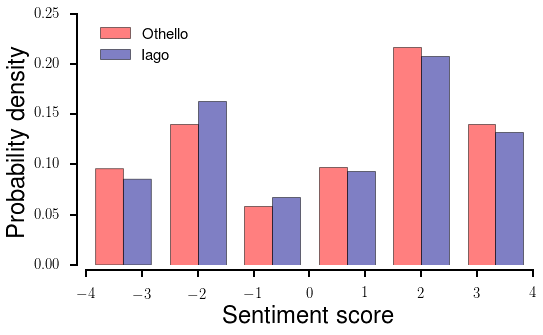

In [7]:
fig = plt.figure( figsize = (8, 4.5) )
sub1 = fig.add_subplot(1,1,1)
my_font_size = 15

half_frame(sub1, "Sentiment score", "Probability density", font_size = my_font_size)

# Calculate and plot histogram
#
sub1.hist([othello_sentiment, iago_sentiment], 6, normed = 1, color = ['r', 'darkblue'], rwidth = 0.75, alpha = 0.5, 
          histtype = "bar", label = ['Othello', 'Iago'], cumulative = False)

# Format legend
sub1.legend(loc = "best", frameon = False, markerscale = 1.8, fontsize = my_font_size)

plt.show()

So, are these distributions different? Let's look at some statistical metrics that might tell us something about this...

In [8]:
results_othello = stat.describe(othello_sentiment)
print(results_othello)
print()
results_iago = stat.describe(iago_sentiment)
print(results_iago)

DescribeResult(nobs=470, minmax=(-4, 4), mean=0.40851063829787232, variance=5.120609717370594, skewness=-0.41543139442792626, kurtosis=-1.3060163694576852)

DescribeResult(nobs=537, minmax=(-4, 4), mean=0.32774674115456237, variance=4.9073070402179058, skewness=-0.29978164467913276, kurtosis=-1.4307035152922654)


In [9]:
# Using t-test

t, p = stat.ttest_ind(othello_sentiment, iago_sentiment, equal_var = False)
print('ttest_ind: \t t =  {0:6.4f}  \t p = {1:6.4f}'.format(t, p) )

ttest_ind: 	 t =  0.5706  	 p = 0.5684


In [10]:
# Using Kolmogorov-Smirnov test

D, p = stat.ks_2samp(othello_sentiment, iago_sentiment)
print('KS 2 samp: \t  D =  {0:6.4f}  \t p = {1:6.4f}'.format(D, p) )

KS 2 samp: 	  D =  0.0272  	 p = 0.9916


In [12]:
# Using chi_square test

hist_othello, edges = np.histogram(othello_sentiment, bins = 6, density = True)
hist_iago, edges = np.histogram(iago_sentiment, bins = 6, density = True)

hist_othello = 100 * np.array(hist_othello)
hist_iago = 100 * np.array(hist_iago)
print(hist_othello)
print(hist_iago)

b = (hist_othello - hist_iago)**2 / hist_iago
print(b)
print(np.cumsum( b ))

chi2 , p = stat.chisquare(hist_othello, hist_othello, ddof = 5)
print(chi2, p)



[  9.57446809  14.04255319   5.90425532   9.73404255  21.70212766
  14.04255319]
[  8.51955307  16.34078212   6.70391061   9.3575419   20.81005587
  13.26815642]
[ 0.13062254  0.32323154  0.09538441  0.0151485   0.03824075  0.04519771]
[ 0.13062254  0.45385409  0.5492385   0.564387    0.60262775  0.64782546]
0.0 nan


In [14]:
import math

# Playing games of chance

# Define outcomes of play
one_die = range(1, 7)

cards = []
card_values = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 
               'Jack', 'Queen', 'King', 'Ace']
suites = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
for value in card_values:
    for suit in suites:
        cards.append(value + " " + suit)

        
no_one_die = len(one_die)
no_cards = len(cards)

print( no_one_die, one_die )
print()
print( no_cards, cards )

6 range(1, 7)

52 ['2 Clubs', '2 Diamonds', '2 Hearts', '2 Spades', '3 Clubs', '3 Diamonds', '3 Hearts', '3 Spades', '4 Clubs', '4 Diamonds', '4 Hearts', '4 Spades', '5 Clubs', '5 Diamonds', '5 Hearts', '5 Spades', '6 Clubs', '6 Diamonds', '6 Hearts', '6 Spades', '7 Clubs', '7 Diamonds', '7 Hearts', '7 Spades', '8 Clubs', '8 Diamonds', '8 Hearts', '8 Spades', '9 Clubs', '9 Diamonds', '9 Hearts', '9 Spades', '10 Clubs', '10 Diamonds', '10 Hearts', '10 Spades', 'Jack Clubs', 'Jack Diamonds', 'Jack Hearts', 'Jack Spades', 'Queen Clubs', 'Queen Diamonds', 'Queen Hearts', 'Queen Spades', 'King Clubs', 'King Diamonds', 'King Hearts', 'King Spades', 'Ace Clubs', 'Ace Diamonds', 'Ace Hearts', 'Ace Spades']


In [16]:
#How many possibilities
def number_states_dice(n, no_one_die = 6):
    """ Returns number of possible sums for n dice""" 
    return 6*n - (n-1)

def number_states_cards(n, no_cards = 52):
    """ Returns number of possible hands of n cards from a single deck""" 
    number = 1
    for i in range(no_cards, no_cards-n, -1):
        number *= i
    return number / math.factorial(n)


print( number_states_dice(3) )
print( number_states_cards(15) )

16
4481381406320.0


In [17]:
import numpy as np

def prob_of_outcome_tossing_n_dice(sum_dots, n, n_attempts = 1000):
    """ Probability of the sum of the dots in n dice being sum_dots"""
    count_successes = 0
    for a in range(n_attempts):
        # Toss dice
        sum_temp = 0
        for i in range(n):
            sum_temp += np.random.randint(6) + 1
        if sum_temp == sum_dots:
            count_successes += 1
    
    return float(count_successes) / n_attempts

print( prob_of_outcome_tossing_n_dice(3, 2, 10) )
print( prob_of_outcome_tossing_n_dice(3, 2, 100) )
print( prob_of_outcome_tossing_n_dice(3, 2) )
print( prob_of_outcome_tossing_n_dice(3, 2, 1000000) )

0.0
0.13
0.056
0.055795


0.0238


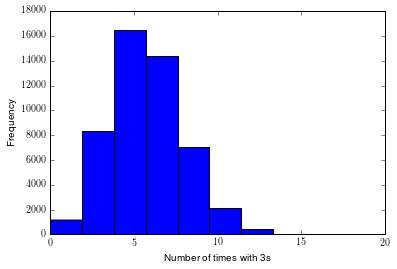

In [19]:
#0.055917 * 100
Number_of_times_I_observed_3 = 11

count_3s = []
extreme = 0
for i in range(50000):
    outcome = 100 * prob_of_outcome_tossing_n_dice(3, 2, 100)
    count_3s.append( outcome )
    if outcome >= 11:
        extreme += 1

print( extreme / float(50000) )
plt.hist(count_3s)
plt.xlabel("Number of times with 3s")
plt.ylabel("Frequency")

plt.show()


In [20]:
# Calculate pi by calculating area of quarter circle

def estimate_pi(n_attempts = 10000):
    """ Estimate pi from area of quarter circle """ 
    count_successes = 0
    for i in range(n_attempts):
        x_rand = np.random.random()
        y_rand = np.random.random()
        dist = math.sqrt( x_rand **2 + y_rand**2 )
        if dist <= 1.:
            count_successes += 1
    return float(count_successes) / n_attempts


print( math.pi / 4. )
print( estimate_pi(10) )

0.7853981633974483
0.9


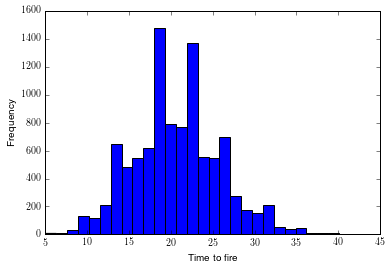

In [22]:
# Calculate distribution of firing times of a model neuron

def time_to_fire( threshold , lamb, scale_size):
    """ Simulate distribution of times for neuron that sums
    inputs and fires when sum exceeds threshold """
    state = 0.
    time = 0.
    while state < threshold: 
        # Update time
        delay_between_inputs = np.random.poisson(lamb)
        time += delay_between_inputs
        
        # Update state
        size_of_input = scale_size * np.random.random()
        state += size_of_input
        
    return time    

# Initialize variables
N_neurons = 10000
threshold = 1.
scale_size = 0.1
lamb = 1.

list_times = []
for neuron in range(N_neurons):
    list_times.append( time_to_fire( threshold , lamb, scale_size) )

    
#print list_times

plt.hist(list_times, 30)
plt.xlabel("Time to fire")
plt.ylabel("Frequency")

plt.show()
